In [1]:
import numpy as np  
import pandas as pd
import xarray as xr
from dbfread import DBF
import dbf
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
import math
from matplotlib import patches
from tqdm import tqdm
import os
import cmaps
from matplotlib.colors import ListedColormap

In [2]:
# 指定两个dbf文件路径
filename1 = "./dataset/SI.dbf"
filename2 = "./dataset/SP.dbf"

# 指定要读取的列名
columns = ['SID', 'year', 'BASIN', 'SUBBASIN', 'NAME',
           'ISO_TIME', 'NATURE', 'LAT', 'LON', 'USA_ATCFID', 
           'DIST2LAND', 'USA_STATUS', 'USA_WIND','WMO_WIND']

# 读取dbf文件中指定列名的数据
data1 = []
for record in DBF(filename1):
    row = []
    for column in columns:
        row.append(record[column])
    data1.append(row)

data2 = []
for record in DBF(filename2):
    row = []
    for column in columns:
        row.append(record[column])
    data2.append(row)

In [3]:
# 将数据转换为DataFrame
df1 = pd.DataFrame(data1, columns=columns)  #168730row
df2 = pd.DataFrame(data2, columns=columns)  #75937row

# 筛选TC，删除非TC以及陆地上的点
# df1_s = df1[df1['USA_STATUS'].isin(['ST', 'TC', 'TD', 'TS', 'TY'])]
df1_s = df1[df1['NATURE'].isin(['TS'])]
df1_s = df1_s[df1_s['DIST2LAND'] != 0]  #共98866行

df2_s = df2[df2['NATURE'].isin(['TS'])]
df2_s = df2_s[df2_s['DIST2LAND'] != 0]  #共50312行


In [4]:
# 筛选出年份在1980-2022年内的数据
df1_year = df1_s[(df1_s['year'] >= 1980) & (df1_s['year'] <= 2023)]

# 筛选出USA_WIND大于等于35的数据
df1_w = df1_year[df1_year['WMO_WIND'] >= 35]

# 检查SID是否有重复，若有重复则保留'USA_WIND'列最接近35的那一行数据
df1_SID = df1_w.sort_values(by=['SID', 'WMO_WIND'])  #按照 SID 和 USA_WIND 列进行升序排序，即先按照 SID 排序，如果 SID 相同，则按照 USA_WIND 排序。
df1_SID.drop_duplicates(subset=['SID'], keep='first', inplace=True)  #若SID重复，保留这些行的第一个

# df2筛选同理
df2_year = df2_s[(df2_s['year'] >= 1980) & (df2_s['year'] <= 2023)]
df2_w = df2_year[df2_year['WMO_WIND'] >= 0]
df2_SID = df2_w.sort_values(by=['SID', 'WMO_WIND'])  
df2_SID.drop_duplicates(subset=['SID'], keep='first', inplace=True)  

# 按照 'year'，'LAT' 和 'LON' 进行分组，并统计每个组的大小
df1_count = df1_SID.groupby(['year', 'LAT', 'LON']).size().reset_index(name='tc')
df2_count = df2_SID.groupby(['year', 'LAT', 'LON']).size().reset_index(name='tc')

# 将两个 DataFrame 拼接在一起
df_concat = pd.concat([df1_count, df2_count], axis=0)
df_concat = df_concat.reset_index(drop=True)
# df_concat

In [44]:
# 创建 'lat' 和 'lon' 的坐标数组
#lat = np.arange(-40,0.5,2.5)  # lat 从 0° 到 40°S，步长 2.5°
# lat = np.arange(0, -45, -2.5)  # lat 从 0° 到 40°S，步长 2.5°
lat = np.arange(0, -45, -5)
# lat = np.arange(0, -40.5, -2.5)  # lat 从 0° 到 40°S，步长 2.5°
# lon = np.arange(0, 360, 2.5)  # lon 从 0 到 360，步长 2.5°
lon = np.arange(0, 360, 5)

In [6]:
def tc_creat(startYear, endYear, lat, lon):
    # 创建 'tc' 变量，并将其写入 DataArray 对象
    tc = xr.DataArray(
        data=np.zeros((len(np.arange(startYear, endYear)), len(lat), len(lon))),
        dims=('year', 'lat', 'lon'),
        coords={'year': np.arange(startYear, endYear), 'lat': lat, 'lon': lon},
    )
    return tc

def sort_year_and_reset_index(df):
    df = df.sort_values(by=['year'],ascending=[True])
    df = df.reset_index(drop=True)
    return df

In [45]:
tc_first = tc_creat(1980, 2006, lat, lon)

tc_second = tc_creat(2006, 2024, lat, lon)

dfFirst = sort_year_and_reset_index(df_concat[(df_concat['year'] <= 2005)])

dfSecond = sort_year_and_reset_index(df_concat[(df_concat['year'] >= 2006)])

In [50]:
def tc_write(df,tc, num_year, lat, lon):
# 将每个格点每年生成的台风数量写入 'tc' 变量.iterrows()
# 将 DataFrame 表中的数据写入 'tc' 变量中相应的位置
    for _, row in df.iterrows():
        year, lat, lon, count = row.values
    #     print(_, year, lat, lon, count)
        year = int(year)                  # 将 year 转换为整数类型
        lat_idx = int(round(-lat / 5))  # 计算 lat 在 'tc' 中的索引
        lon_idx = int(round(lon / 5))   # 计算 lon 在 'tc' 中的索引
        tc[year-num_year, lat_idx, lon_idx-1] = count
    return tc


In [51]:
tcFirst = tc_write(dfFirst, tc_first, 1980, lat, lon)

In [53]:
tcFirst.shape

(26, 9, 72)

In [54]:
taifeng_sum_first = np.zeros((9,72),dtype=float)
for i in range(1980, 2006):
    tcYear = tc_creat(i, i+1, lat, lon)
    dfYear = sort_year_and_reset_index(df_concat[(df_concat['year'] == i)])
    tcYear2Next = tc_write(dfYear, tcYear, i, lat, lon)
    taifeng_sum_first += tcYear2Next[0].data

In [55]:
taifeng_sum_second = np.zeros((9,72),dtype=float)
for i in range(2006, 2024):
    tcYear = tc_creat(i, i+1, lat, lon)
    dfYear = sort_year_and_reset_index(df_concat[(df_concat['year'] == i)])
    tcYear2Next = tc_write(dfYear, tcYear, i, lat, lon)
    taifeng_sum_second += tcYear2Next[0].data

In [56]:
taifeng_sum_diff = taifeng_sum_second - taifeng_sum_first

In [11]:
# tc1980to2006 = tc_write(df1980, tc1980, 1980, lat, lon)
# tc2009to2023 = tc_write(df2007, tc2007, 2007, lat, lon)

In [42]:
# lat = np.arange(0, -45, -5)  # lat 从 0° 到 40°S，步长 2.5°
# # lat = np.arange(0, -40.5, -2.5)  # lat 从 0° 到 40°S，步长 2.5°
# lon = np.arange(0, 360, 5)  # lon 从 0 到 360，步长 2.5°

# 显著性打点设置为95%
# area1 = np.where(p_value1982 < 0.05)
# area2 = np.where(p_value2009 < 0.05)
nx,ny = np.meshgrid(lon,lat)

In [57]:
taifeng_sum_diff.min()

-10.0

In [58]:
taifeng_sum_diff.max()

4.0

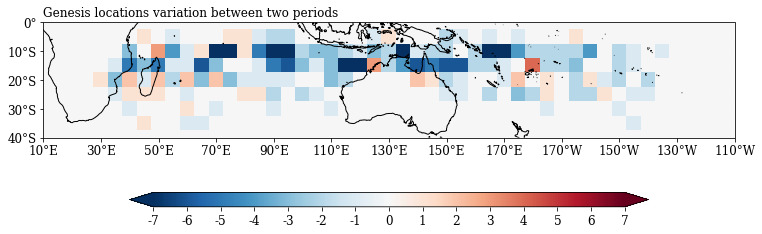

In [60]:
from matplotlib import colors,cm
import matplotlib as mpl

config = {
    "font.family": 'serif',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 7.0
MIN = -7.0

fig = plt.figure(figsize=(12,8))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (10,240,-40,0)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

ax = fig.add_axes([0.1, 0.12, 0.8, 0.6],projection = proj)
ax.set_extent(img_extent, crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])
#ax.add_feature(land,facecolor='0.75')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(leftlon,rightlon+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
c1 = ax.pcolor(lon, lat,
#                levels=[0],
               taifeng_sum_diff, zorder=0, vmin=MIN, vmax=MAX, 
               transform=ccrs.PlateCarree(), 
               cmap=plt.cm.RdBu_r,
#                cmap=newcmap_1
              )
# sig1 = ax.scatter(nx[area1], ny[area1],marker = '.',s=6, linewidths=1.3, c='purple',alpha=0.7,transform=ccrs.PlateCarree())
ax.set_title('Genesis locations variation between two periods',
             loc='left',fontsize =12)

# colorbar
position = fig.add_axes([0.2, 0.20,  0.6, 0.025]) # 最下面位置
norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值
fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
                                      ),
                 cax = position,
                 orientation='horizontal',
                 ticks=np.arange(MIN, MAX+0.01, 1).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.02) 
# position=fig.add_axes([0.2, 0.22,  0.6, 0.025])
# cmap_ticks = [i for i in np.arange(MIN, MAX+0.01, 0.03)]
# fig.colorbar(c1,cax=position,ticks=cmap_ticks,orientation='horizontal',format='%.2f')

plt.savefig('TC_new_20231031.png', dpi=600, bbox_inches='tight',pad_inches = 0.2)
plt.show()